<a href="https://colab.research.google.com/github/Jaimemorillo/covid-assignment/blob/main/survival_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/covid_assignment/COVID19_data.csv'

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

## Preprocessing

In [ ]:
df = pd.read_csv(
    data_path,
    sep=',', 
    header='infer',
    index_col = "ID"
)
# remove DESTIONATION column
df.pop("DESTINATION")

# fetch categorical columns before doing any other preprocessing
cat_mask = (df.dtypes == object)
cat_cols= df.columns[cat_mask].tolist()

# remove all rows containing NA values (47 of them)
df = df.dropna()

# drop all rows where the important values are all 0
df = df.drop(df[(df["TEMP"] == 0) & (df["HEART_RATE"] == 0) &  (df["GLUCOSE"] == 0) & ( df["SAT_O2"] == 0) & (df["BLOOD_PRES_SYS"] == 0) & (df["BLOOD_PRES_DIAS"] == 0)].index)

# only remove the very big outliers, the smaller ones might be relevant
df = df.drop(df[(df["HEART_RATE"] > 400)].index)
df = df.drop(df[(df["BLOOD_PRES_SYS"] > 600)].index)
df = df.drop(df[(df["BLOOD_PRES_DIAS"] > 400)].index)
df = df.drop(df[(df["AGE"] > 180)].index)

# create 2 separate dataframes, categorical and numerical
df_cat = df[cat_cols]
df_num = df.drop(cat_cols, axis = 1)
# does a bit encoding for SEX and EXITUS
d = defaultdict(preprocessing.LabelEncoder)
df_cat_le = df_cat.apply(lambda col: d[col.name].fit_transform(col))

df = pd.merge(left = df_cat_le, right = df_num, on = "ID")


In [ ]:
df.shape

(1641, 11)

In [ ]:
df.EXITUS.value_counts()

0    1374
1     267
Name: EXITUS, dtype: int64

## Slipt train and test (test 20%)

Stardscaler is applied

In [ ]:
X = df.drop(['EXITUS'], axis=1)
y = df['EXITUS'].values

# Scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

print('Size train: ' + str(len(X_train)))
print('Size test: ' + str(len(X_test)))

Size train: 1312
Size test: 329


## Grid search and cross-validation

5-fold

In [ ]:
parameters = {
              'C': [1, 0.1, 0.01],
              'max_iter': [100, 300, 700],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

lr = LogisticRegression(random_state=9) ## Model
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=9),
             param_grid={'C': [1, 0.1, 0.01], 'max_iter': [100, 300, 700],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

## Results

### Best params

In [ ]:
print(clf.best_params_) #Best parameters selected
pd.DataFrame(clf.cv_results_) # Dataframe with every train

{'C': 0.1, 'max_iter': 100, 'solver': 'newton-cg'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022902,0.007478,0.000593,0.000008,1,100,newton-cg,"{'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
1,0.010030,0.000171,0.000611,0.000019,1,100,lbfgs,"{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
2,0.004119,0.000109,0.000645,0.000039,1,100,liblinear,"{'C': 1, 'max_iter': 100, 'solver': 'liblinear'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
3,0.016453,0.001790,0.000735,0.000076,1,100,sag,"{'C': 1, 'max_iter': 100, 'solver': 'sag'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
4,0.020989,0.002143,0.000733,0.000370,1,100,saga,"{'C': 1, 'max_iter': 100, 'solver': 'saga'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
5,0.017451,0.000949,0.000604,0.000006,1,300,newton-cg,"{'C': 1, 'max_iter': 300, 'solver': 'newton-cg'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
6,0.011477,0.004433,0.000658,0.000172,1,300,lbfgs,"{'C': 1, 'max_iter': 300, 'solver': 'lbfgs'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
7,0.004945,0.002052,0.000627,0.000043,1,300,liblinear,"{'C': 1, 'max_iter': 300, 'solver': 'liblinear'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
8,0.016116,0.001480,0.000673,0.000036,1,300,sag,"{'C': 1, 'max_iter': 300, 'solver': 'sag'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16
9,0.020225,0.003249,0.000551,0.000028,1,300,saga,"{'C': 1, 'max_iter': 300, 'solver': 'saga'}",0.855513,0.859316,0.854962,0.847328,0.870229,0.857470,0.007472,16


### Final metrics (test)

AUC: 0.811
Acc: 0.845
Precision: 0.636
Recall: 0.13
F1: 0.215
Conf. Matrix: 


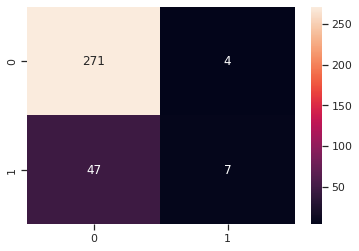

In [ ]:
y_pred = clf.predict(X_test)
print('AUC: ' + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]).round(3)))

def plot_metrics(y_test, y_pred):
  print('Acc: ' + str(accuracy_score(y_test, y_pred).round(3)))
  print('Precision: ' + str(precision_score(y_test, y_pred).round(3)))
  print('Recall: ' + str(recall_score(y_test, y_pred).round(3)))
  print('F1: ' + str(f1_score(y_test, y_pred).round(3)))
  print('Conf. Matrix: ')
  #print(confusion_matrix(y_test, y_pred))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

  return None

plot_metrics(y_test,y_pred)